<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [K3WINE1] - Wine quality prediction with a Dense Network (DNN)
  <!-- DESC -->  Another example of regression, with a wine quality prediction, using Keras 3 and PyTorch
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predict the **quality of wines**, based on their analysis
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Wine Quality datasets](https://archive.ics.uci.edu/ml/datasets/wine+Quality)** are made up of analyses of a large number of wines, with an associated quality (between 0 and 10)  
This dataset is provide by :  
Paulo Cortez, University of Minho, Guimarães, Portugal, http://www3.dsi.uminho.pt/pcortez  
A. Cerdeira, F. Almeida, T. Matos and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal, @2009  
This dataset can be retreive at [University of California Irvine (UCI)](https://archive.ics.uci.edu/dataset/186/wine+quality)


Due to privacy and logistic issues, only physicochemical and sensory variables are available  
There is no data about grape types, wine brand, wine selling price, etc.

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality (score between 0 and 10)

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init


In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

import numpy as np
import pandas as pd

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('K3WINE1')

<br>**FIDLE - Environment initialization**

Version              : 2.3.2
Run id               : K3WINE1
Run dir              : ./run/K3WINE1
Datasets dir         : /home/dorian/fidle-tp/datasets-fidle
Start time           : 15/08/24 10:46:56
Hostname             : Victus-DT (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/K3WINE1/figs (False)
keras                : 3.5.0
numpy                : 1.26.3
sklearn              : 1.5.1
yaml                 : 6.0.2
matplotlib           : 3.9.2
pandas               : 2.2.2
torch                : 2.4.0+cu124


Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [2]:
fit_verbosity = 1
dataset_name  = 'winequality-red.csv'

Override parameters (batch mode) - Just forget this cell

In [3]:
fidle.override('fit_verbosity', 'dataset_name')

## Step 2 - Retrieve data

In [4]:
data = pd.read_csv(f'{datasets_dir}/WineQuality/origine/{dataset_name}', header=0,sep=';')

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5.00
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5.00
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6.00
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00


Missing Data :  0   Shape is :  (1599, 12)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be the data of the analysis and y the quality

In [5]:
# ---- Split => train, test
#
data       = data.sample(frac=1., axis=0)     # Shuffle
data_train = data.sample(frac=0.8, axis=0)    # get 80 %
data_test  = data.drop(data_train.index)      # test = all - train

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('quality',  axis=1)
y_train = data_train['quality']
x_test  = data_test.drop('quality',   axis=1)
y_test  = data_test['quality']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (1599, 12)
x_train :  (1279, 11) y_train :  (1279,)
x_test  :  (320, 11) y_test  :  (320,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [6]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.34,0.53,0.27,2.53,0.09,15.80,46.14,1.00,3.31,0.66,10.42
std,1.77,0.18,0.19,1.44,0.05,10.52,32.81,0.00,0.16,0.17,1.04
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50
50%,7.90,0.52,0.26,2.20,0.08,13.00,38.00,1.00,3.31,0.62,10.20
75%,9.20,0.64,0.42,2.60,0.09,21.00,61.00,1.00,3.40,0.73,11.10
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.11,-2.28,-1.39,-1.14,-1.64,-1.41,-1.22,-3.49,-3.67,-1.97,-1.94
25%,-0.70,-0.77,-0.92,-0.44,-0.37,-0.84,-0.74,-0.60,-0.64,-0.65,-0.88
50%,-0.25,-0.04,-0.05,-0.23,-0.18,-0.27,-0.25,-0.01,0.00,-0.23,-0.21
75%,0.48,0.63,0.77,0.05,0.08,0.49,0.45,0.57,0.58,0.42,0.65
max,4.26,5.89,3.74,9.01,11.42,5.34,7.40,3.63,4.52,8.01,4.29


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://keras.io/api/optimizers)
 - [Activation](https://keras.io/api/layers/activations)
 - [Loss](https://keras.io/api/losses)
 - [Metrics](https://keras.io/api/metrics)

In [7]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## 5 - Train the model
### 5.1 - Get it

In [8]:
model=get_model_v1( (11,) )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_n1 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_n2 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,993 (19.50 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

### 5.2 - Add callback

In [9]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.keras"

savemodel_callback = keras.callbacks.ModelCheckpoint( filepath=save_dir, monitor='val_mae', mode='max', save_best_only=True)

### 5.3 - Train it

In [10]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.8564 - mae: 3.0665 - mse: 12.8564 - val_loss: 1.4487 - val_mae: 0.9710 - val_mse: 1.4487
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6272 - mae: 1.0064 - mse: 1.6272 - val_loss: 1.0298 - val_mae: 0.8107 - val_mse: 1.0298
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0662 - mae: 0.7963 - mse: 1.0662 - val_loss: 0.8814 - val_mae: 0.7381 - val_mse: 0.8814
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7073 - mae: 0.6509 - mse: 0.7073 - val_loss: 0.6673 - val_mae: 0.6401 - val_mse: 0.6673
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6131 - mae: 0.5962 - mse: 0.6131 - val_loss: 0.5722 - val_mae: 0.5942 - val_mse: 0.5722
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4582 - mae: 0.5283 - mse: 0.4582 - val_loss: 0.5852 - val_mae: 0.5943 - val_mse: 0.5852
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4392 - mae: 0.5131 - mse: 0.4

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.5529
x_test / mae       : 0.5470
x_test / mse       : 0.5529


### 6.2 - Training history
What was the best result during our training ?

In [12]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.4984


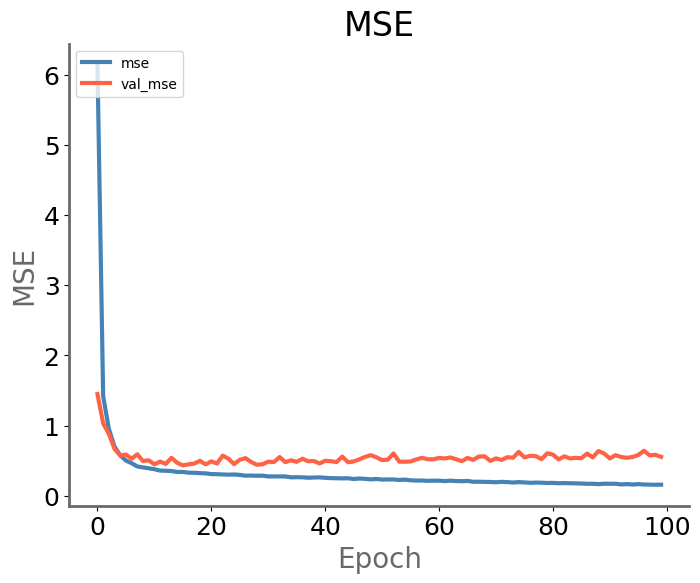

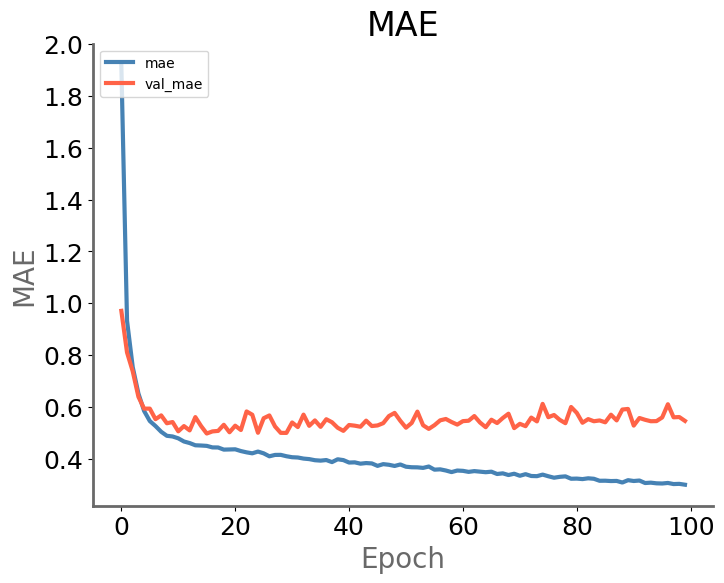

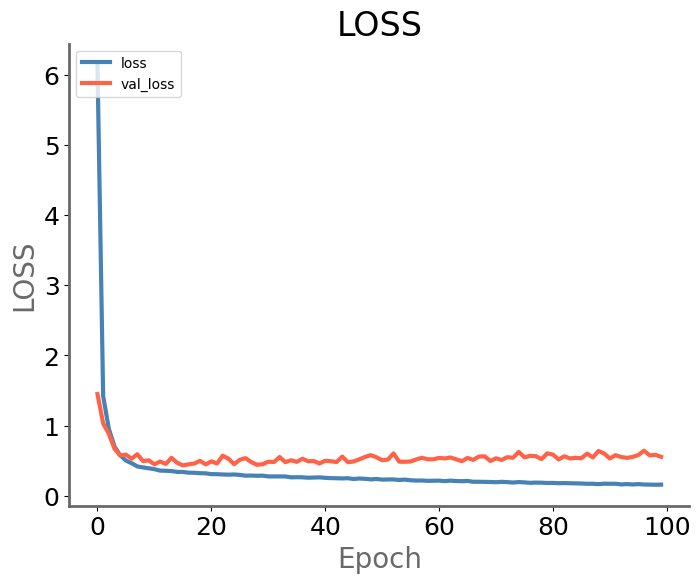

In [13]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [14]:
loaded_model = keras.models.load_model('./run/models/best_model.keras')
loaded_model.summary()
print("Loaded.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_n1 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_n2 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,988 (39.02 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,995 (19.51 KB)

Loaded.


### 7.2 - Evaluate it :

In [15]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 1.4487
x_test / mae       : 0.9710
x_test / mse       : 1.4487


### 7.3 - Make a prediction

In [16]:
# ---- Pick n entries from our test set
n = 200
ii = np.random.randint(1,len(x_test),n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [17]:
# ---- Make a predictions
y_pred = loaded_model.predict( x_sample, verbose=2 )

7/7 - 0s - 1ms/step


In [18]:
# ---- Show it
print('Wine    Prediction   Real   Delta')
for i in range(n):
    pred   = y_pred[i][0]
    real   = y_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Wine    Prediction   Real   Delta
000        3.86       5      +1.14 
001        5.82       6      +0.18 
002        6.09       5      -1.09 
003        5.44       6      +0.56 
004        4.80       6      +1.20 
005        4.26       5      +0.74 
006        6.79       8      +1.21 
007        6.21       5      -1.21 
008        7.31       6      -1.31 
009        3.46       6      +2.54 
010        5.67       6      +0.33 
011        6.46       7      +0.54 
012        5.34       6      +0.66 
013        3.99       5      +1.01 
014        5.14       5      -0.14 
015        4.74       6      +1.26 
016        3.66       5      +1.34 
017        4.09       7      +2.91 
018        5.85       6      +0.15 
019        5.70       3      -2.70 
020        6.54       5      -1.54 
021        6.14       5      -1.14 
022        4.96       5      +0.04 
023        5.20       7      +1.80 
024        4.42       5      +0.58 
025        5.93       7      +1.07 
026        5.67       7      +

### Few questions :
- Can this model be used for red wines from Bordeaux and/or Beaujolais?
- What are the limitations of this model?
- What are the limitations of this dataset?

In [19]:
fidle.end()

**End time :** 15/08/24 10:48:17  
**Duration :** 00:01:21 030ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>